# 1.1. Set up

In [1]:
from functions import my_functions as mf
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE 
from math import ceil
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix, f1_score, recall_score
from IPython.display import Image
from warnings import filterwarnings
filterwarnings(action='ignore')
%matplotlib inline   
%load_ext blackcellmagic

In [97]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:.2f}".format)

In [98]:
df = pd.read_csv('insurance_numeric_df.csv')
df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,annual_income_per_person,traveller
0,31,0,1,400000,6,1,0,0,0,66666.67,0
1,31,1,1,1250000,7,0,0,0,0,178571.43,0
2,34,1,1,500000,4,1,0,0,1,125000.00,0
3,28,1,1,700000,3,1,0,0,0,233333.33,0
4,28,1,1,700000,8,1,1,0,0,87500.00,0


# 2. Predicting values of travel_insurance column

In this part i will try to predict: will a person buy travel insurance with covid-19 coverage or not.

## 2.1. Feature pre-processing

As all features in this usable data set are numeric, the only pre-processing I need to do is scaling for numerical continuous variables: age, annual_income, annual_income_per_person, family_members, as the scale of these values differ quite a lot. Some values were added in the EDA as part of feature engineering.

In [99]:
df.head()

,age,employment_type,graduate_or_not,annual_income,family_members,chronic_diseases,frequent_flyer,ever_travelled_abroad,travel_insurance,annual_income_per_person,traveller
0,31,0,1,400000,6,1,0,0,0,66666.67,0
1,31,1,1,1250000,7,0,0,0,0,178571.43,0
2,34,1,1,500000,4,1,0,0,1,125000.00,0
3,28,1,1,700000,3,1,0,0,0,233333.33,0
4,28,1,1,700000,8,1,1,0,0,87500.00,0


In [100]:
df_result = df.copy()

# Identify and drop our target variable 'travel_insurance' from data frame, isolating our independent variables
X = df_result.drop(columns = ['travel_insurance'], axis = 1)

# Isolate our dependent variable as a feature
y = df_result.travel_insurance

* Splitting the data sets.

In [101]:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size=0.8, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=123)

In [102]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1589, 10)
(199, 10)
(199, 10)
(1589,)
(199,)
(199,)


In [103]:
# Let's check the number of labels in y-train data set.

Counter(y_train)

Counter({1: 579, 0: 1010})

We see, that data is imbalanced, so for the main score I'll use F1. I will select the best models by F1 parameters, as it's the harmonic mean of precision and recall scores. Also my interest is that the model could better predict more false positives than false negatives, as by predicting false negative - when a person is interested in insurance, but the Company will not offer him by prediction - it would be huge disadvantage, I also care about the recall.

In [117]:
numerical_features = [
    "age",
    "annual_income",
    "family_members",
    "annual_income_per_person",
]

numerical_scaler = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[("numerical", numerical_scaler, numerical_features)],
    remainder="passthrough",
)

## 2.2. Cross-validation of different model/Selecting 3 best

In [11]:
mf.base_line(X_train, y_train, preprocessor)

,Balanced accuracy,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
Logistic regression,0.704085,0.763383,0.704085,0.772373,0.715721,0.757942,0.027789
Decision Tree,0.727381,0.758342,0.727381,0.740751,0.732307,0.731940,0.005870
Random Forest,0.754961,0.792951,0.754961,0.786603,0.764993,0.786598,0.121460
Linear SVC,0.691126,0.755826,0.691126,0.769284,0.701780,0.755673,0.029571
SVC,0.762444,0.813715,0.762444,0.833724,0.779065,0.793416,0.038142
KNN,0.729291,0.771567,0.729291,0.763113,0.739065,0.774746,0.006233


Conclusion: by F1 score and recall best models in this cross-validation on all dataset: 
SVC, KNN, Random forest.

## 2.3. Support vector machine - SVC

### 2.3.1. Simple SVC - no hyper parameters tuned

Let's create SVC model with default parameters and fit all training data.

In [12]:
pipe_sv = Pipeline(steps=[('preprocessor', preprocessor), ('classifier',SVC())])

pipe_sv.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'annual_income',
                                                   'family_members',
                                                   'annual_income_per_person'])])),
                ('classifier', SVC())])

In [13]:
y_hat_train_svc = pipe_sv.predict(X_train)
y_hat_val_svc = pipe_sv.predict(X_val)

* Evaluating Model Performance

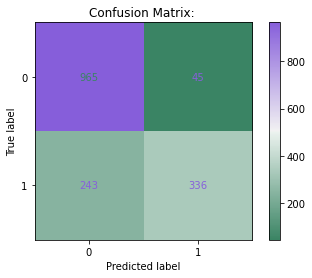

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1010
           1       0.88      0.58      0.70       579

    accuracy                           0.82      1589
   macro avg       0.84      0.77      0.79      1589
weighted avg       0.83      0.82      0.81      1589




In [14]:
mf.plot_classifier_scores(pipe_sv, X_train, y_train, y_hat_train_svc)

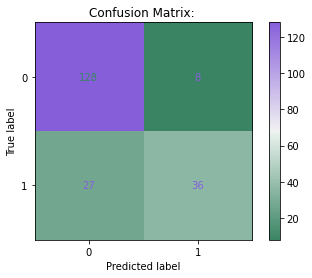

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       136
           1       0.82      0.57      0.67        63

    accuracy                           0.82       199
   macro avg       0.82      0.76      0.78       199
weighted avg       0.82      0.82      0.81       199




In [15]:
mf.plot_classifier_scores(pipe_sv, X_val, y_val, y_hat_val_svc)

* Recall of and f1 score of label '1' does not satisfy me. As I'm interested in better guessing of people who are interested in insurance, than those who are not. So further steps would be to tune the model hyper parameters, maybe use only balanced data (equal number of '0' and '1'), select only some features for prediction.

### 2.3.2. Hyper parameter tuning SVC with RandomizedSearchCv.

In [16]:
mf.SVC_randomized_search(X_train, y_train, pipe_sv)

Best params:
{'classifier': SVC(C=1.0871332741421738, gamma=1), 'classifier__C': 1.0871332741421738, 'classifier__class_weight': None, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Best f1 score in randomized search:
0.6828146370191674


* Lets' fit training data.

In [17]:
pipe_sv_tuned = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(C=1.0871332741421738, gamma=1))])

pipe_sv_tuned.fit(X_train, y_train)
y_hat_train_SVC = pipe_sv_tuned.predict(X_train)

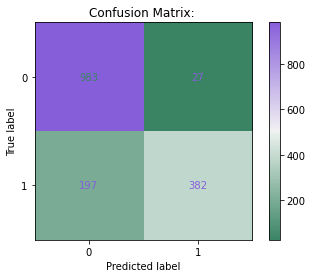

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1010
           1       0.88      0.58      0.70       579

    accuracy                           0.82      1589
   macro avg       0.84      0.77      0.79      1589
weighted avg       0.83      0.82      0.81      1589




In [18]:
mf.plot_classifier_scores(pipe_sv_tuned, X_train, y_train, y_hat_train_svc)

In [19]:
y_hat_val_SVC = pipe_sv_tuned.predict(X_val)

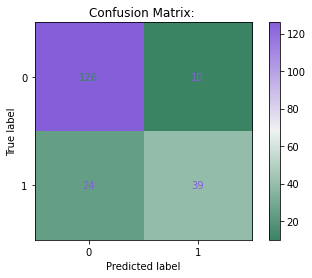

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       136
           1       0.82      0.57      0.67        63

    accuracy                           0.82       199
   macro avg       0.82      0.76      0.78       199
weighted avg       0.82      0.82      0.81       199




In [20]:
mf.plot_classifier_scores(pipe_sv_tuned, X_val, y_val, y_hat_val_svc)

There is not much of improvement. Of the class '1' the recall is still 0.57, f1 score - 0.67.

### 2.3.3. SVC without duplicated values

From the EDA part we saw, that there are quite a lot duplicated values, which also can cause worse performance of the model. So let's try to train model without duplicated values.

In [108]:
X_train_no_dupl = X_train.copy()
X_train_no_dupl.drop_duplicates(inplace = True)

# Set y-train to only include entries which correspond with X_train_no_dupl.
y_train_no_dupl = y_train.loc[X_train_no_dupl.index]

print(X_train_no_dupl.shape)
print(y_train_no_dupl.shape)

(952, 10)
(952,)


In [109]:
pipe_sv_tuned_no_dupl = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(C=1.0871332741421738, gamma=1))])

pipe_sv_tuned_no_dupl.fit(X_train_no_dupl, y_train_no_dupl)
y_hat_train_no_dupl = pipe_sv_tuned_no_dupl.predict(X_train_no_dupl)

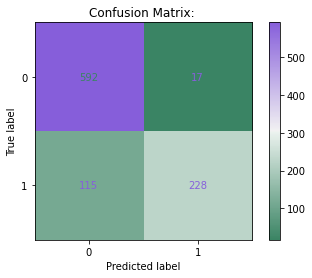

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       609
           1       0.93      0.66      0.78       343

    accuracy                           0.86       952
   macro avg       0.88      0.82      0.84       952
weighted avg       0.87      0.86      0.85       952




In [110]:
mf.plot_classifier_scores(pipe_sv_tuned_no_dupl, X_train_no_dupl, y_train_no_dupl, y_hat_train_no_dupl)

On training data this model predicts better. Let's see on validation data.

In [24]:
y_hat_val_no_dupl = pipe_sv_tuned_no_dupl.predict(X_val)

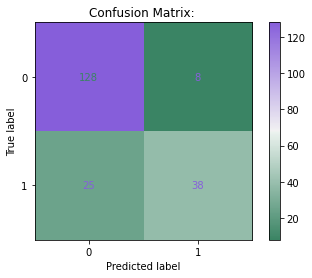

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       136
           1       0.83      0.60      0.70        63

    accuracy                           0.83       199
   macro avg       0.83      0.77      0.79       199
weighted avg       0.83      0.83      0.83       199




In [25]:
mf.plot_classifier_scores(pipe_sv_tuned_no_dupl, X_val, y_val, y_hat_val_no_dupl)

Wohooo, it actually did a little bit better on new data, of the class '1' recall is even 0.6, f1 score - 0.7. Let's try to improve a little bit more.

### 2.3.4. SVC with under sampled data set, no duplicates

In [111]:
undersample1 = RandomUnderSampler(sampling_strategy='majority')
X_train_no_dupl_under, y_train_no_dupl_under = undersample1.fit_resample(X_train_no_dupl, y_train_no_dupl)
print(Counter(y_train_no_dupl_under))

Counter({0: 343, 1: 343})


I got a very very small data set for training, but let's see what happens.

In [112]:
pipe_sv_tuned_no_dupl_under = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(C=1.0871332741421738, gamma=1))])

pipe_sv_tuned_no_dupl_under.fit(X_train_no_dupl_under, y_train_no_dupl_under)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'annual_income',
                                                   'family_members',
                                                   'annual_income_per_person'])])),
                ('classifier', SVC(C=1.0871332741421738, gamma=1))])

In [113]:
y_hat_val_no_dupl_under = pipe_sv_tuned_no_dupl_under.predict(X_val)

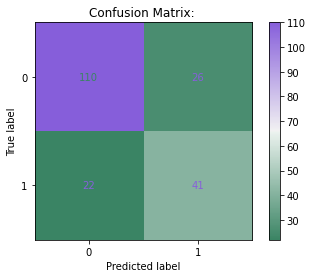

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       136
           1       0.61      0.65      0.63        63

    accuracy                           0.76       199
   macro avg       0.72      0.73      0.73       199
weighted avg       0.76      0.76      0.76       199




In [114]:
mf.plot_classifier_scores(pipe_sv_tuned_no_dupl_under, X_val, y_val, y_hat_val_no_dupl_under)

It's better, but not enough, I think the data set without duplicates and undersampled is just too small for good training of this model.

### 2.3.5. SVC with less features

In SVC I'm using kernel = 'rbf', I'll try to find best features for SVC with sklearn.inspection.permutation_importance and later put only the most important ones into the last model of SVC with no duplicates.
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature, [more info here](https://scikit-learn.org/stable/modules/permutation_importance.html).

Text(0.5, 0, 'Permutation Importance')

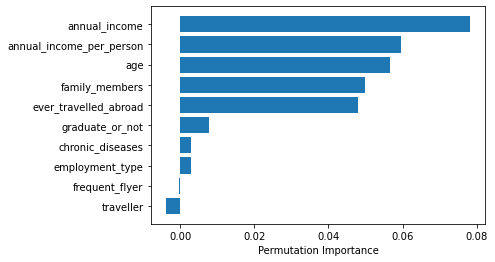

In [115]:
perm_importance = permutation_importance(
    pipe_sv_tuned_no_dupl, X_val, y_val, n_repeats=30, random_state=123
)

feature_names = X_train_no_dupl.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')

Let's leave 5 most important by permutation importance.

In [89]:
X_train_perm_imp = X_train_no_dupl.copy()
X_train_perm_imp = X_train_perm_imp.drop(
    columns=[
        "employment_type",
        "traveller",
        "chronic_diseases",
        "frequent_flyer",
        "graduate_or_not",
    ],
    axis=1,
)
X_train_perm_imp.columns

Index(['age', 'annual_income', 'family_members', 'ever_travelled_abroad',
       'annual_income_per_person'],
      dtype='object')

In [32]:
X_val_perm_imp = X_val.copy()
X_val_perm_imp = X_val_perm_imp.drop(columns=['employment_type', 'traveller', 'chronic_diseases', 'frequent_flyer', 'graduate_or_not'], axis=1)
X_val_perm_imp.columns

Index(['age', 'annual_income', 'family_members', 'ever_travelled_abroad',
       'annual_income_per_person'],
      dtype='object')

In [87]:
pipe_sv_tuned_no_dupl_less = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(C=1.0871332741421738, gamma=1)),
    ]
)

pipe_sv_tuned_no_dupl_less.fit(X_train_perm_imp, y_train_no_dupl)
y_hat_train_no_dupl_less = pipe_sv_tuned_no_dupl_less.predict(X_train_perm_imp)
y_hat_val_no_dupl_less = pipe_sv_tuned_no_dupl_less.predict(X_val_perm_imp)

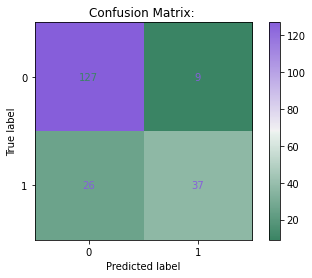

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       136
           1       0.80      0.59      0.68        63

    accuracy                           0.82       199
   macro avg       0.82      0.76      0.78       199
weighted avg       0.82      0.82      0.82       199




In [34]:
mf.plot_classifier_scores(pipe_sv_tuned_no_dupl_less, X_val_perm_imp, y_val, y_hat_val_no_dupl_less)

And actually it did not do better with less features. The best model is still SVC trained on data without duplicates.

## 2.4. K-nearest neighbors

### 2.4.1. KNN with tuned hyper parameters

In this part first of all I'll try to find best scaler for this data set, to see if dimensionality reduction (PCA) would help and the best hyper parameters for KNN.

In [ ]:
study = optuna.create_study(direction='maximize', study_name='SCALER_PCA_KNN') 
func = lambda trial: mf.KNN_objective(trial, X_train, y_train, numerical_features)
study.optimize(func, n_trials=200)

In [36]:
trial = study.best_trial
scaler_pca_KNN = study.best_trial.params
for key, value in scaler_pca_KNN.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		scalers: standard
		dim_red: None
		knn_n_neighbors: 9
		knn_metric: manhattan
		knn_weights: distance
	Best value (f1): 0.66787


As we see optuna suggests that scaler should be standard and no dimensionality reduction should be done. But the metric is suggested 'manhattan', 'weights' - distance. So I can train the KNN model on my set 'preprocessor' (with Standard scaler) and set only these KNN hyper parameters.

* Let's fit all the training data.

In [85]:
knn = KNeighborsClassifier(n_neighbors=9, metric='manhattan', weights='distance')

pipe_knn = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', knn)])

pipe_knn.fit(X_train, y_train)
y_hat_train_knn = pipe_knn.predict(X_train)
y_hat_val_knn = pipe_knn.predict(X_val)

* Let's see how it went with the training data.

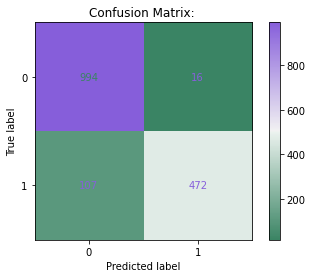

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1010
           1       0.97      0.82      0.88       579

    accuracy                           0.92      1589
   macro avg       0.94      0.90      0.91      1589
weighted avg       0.93      0.92      0.92      1589




In [38]:
mf.plot_classifier_scores(pipe_knn, X_train, y_train, y_hat_train_knn)

It seems like over fitting the data.

* With validation data.

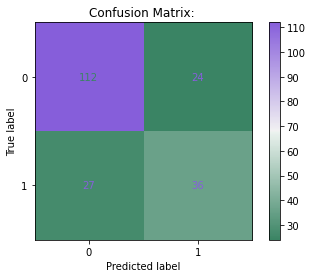

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       136
           1       0.60      0.57      0.59        63

    accuracy                           0.74       199
   macro avg       0.70      0.70      0.70       199
weighted avg       0.74      0.74      0.74       199




In [39]:
mf.plot_classifier_scores(pipe_knn, X_val, y_val, y_hat_val_knn)

So we see that the result is not satisfying, as the model does not predict '1' effective on validation data. We see that it miss classified '1' as '0' even 27 times. Let's try to under sample training data set.

### 2.4.2. KNN with under sampled examples

In [40]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_train_under))

Counter({0: 579, 1: 579})


Let's see what hyper parameters we get on this data set.

In [ ]:
study = optuna.create_study(direction='maximize', study_name='SCALER_PCA_KNN')
func = lambda trial: mf.KNN_objective(trial, X_train_under, y_train_under, numerical_features)
study.optimize(func, n_trials=200)

In [42]:
trial1 = study.best_trial
scaler_pca_KNN1 = study.best_trial.params
for key, value in scaler_pca_KNN1.items():
    print(f'\t\t{key}: {value}')

print(f'\tBest value (f1): {study.best_value:.5f}')


		scalers: robust
		dim_red: PCA
		pca_n_components: 2
		knn_n_neighbors: 10
		knn_metric: minkowski
		knn_weights: distance
	Best value (f1): 0.70309


Scaler is still Standard, no dimensionality reduction, but we have different metrics.

In [84]:
knn1 = KNeighborsClassifier(n_neighbors=10, metric='minkowski', weights='uniform')
pipe_knn_undersample = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dim_red', PCA(n_components=2)),
        ('classifier', knn1),
    ]
)

In [44]:
pipe_knn_undersample.fit(X_train_under, y_train_under)
y_hat_train_under = pipe_knn_undersample.predict(X_train_under)
y_hat_val_under = pipe_knn_undersample.predict(X_val)

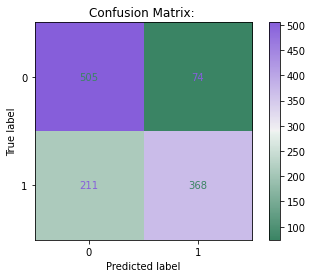

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       579
           1       0.83      0.64      0.72       579

    accuracy                           0.75      1158
   macro avg       0.77      0.75      0.75      1158
weighted avg       0.77      0.75      0.75      1158




In [45]:
mf.plot_classifier_scores(pipe_knn_undersample, X_train_under, y_train_under, y_hat_train_under)

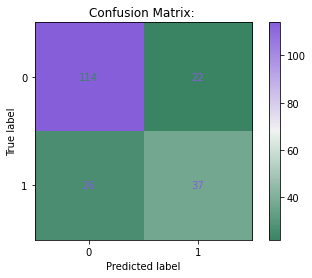

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       136
           1       0.63      0.59      0.61        63

    accuracy                           0.76       199
   macro avg       0.72      0.71      0.72       199
weighted avg       0.76      0.76      0.76       199




In [46]:
mf.plot_classifier_scores(pipe_knn_undersample, X_val, y_val, y_hat_val_under)

All in all I got a little bit better performance, of recall 59 percent in the guessing '1', f1 is 0.61, slightly better than in the previous round. But in total in the base line model I got 0.77 macro f1 and here I got only 0.72, so no tuning and under sampling helped.

## 2.5. Random Forest

### 2.5.1. Random Forest with tuned hyper parameters

In [ ]:
study = optuna.create_study(direction='maximize', study_name='RandomForestClassifier')
func = lambda trial: mf.random_forest_objective(trial, X_train, y_train)
study.optimize(func, n_trials=200)

In [81]:
trial_rf = study.best_trial
random_forest = trial_rf.params
for key, value in random_forest.items():
    print(f'\t\t{key}: {value}')

		n_estimators: 81
		max_depth: 5
		min_samples_split: 7
		min_samples_leaf: 2
		max_features: 2
		weight: None


* Let's fit the training data into RandomForest.

In [49]:
rf = RandomForestClassifier(n_estimators=220, max_depth=10, min_samples_split=3, min_samples_leaf=2, max_features=4, bootstrap=True, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=4, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=220, oob_score=True)

* We can cher the out of bag score (the same as accuracy) of the samples, that were not used in training.

In [50]:
rf.oob_score_

0.8231592196349906

So it is very close to the macro accuracy of the bae line Random Forest model.

* Let's predict on training and validation data.

In [51]:
y_hat_train_rf = rf.predict(X_train)
y_hat_val_rf = rf.predict(X_val)

* results on training data.

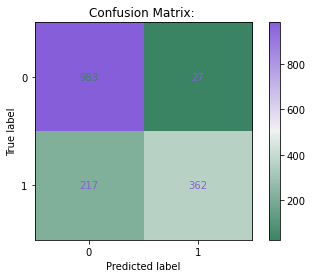

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1010
           1       0.93      0.63      0.75       579

    accuracy                           0.85      1589
   macro avg       0.87      0.80      0.82      1589
weighted avg       0.86      0.85      0.84      1589




In [52]:
mf.plot_classifier_scores(rf, X_train, y_train, y_hat_train_rf)

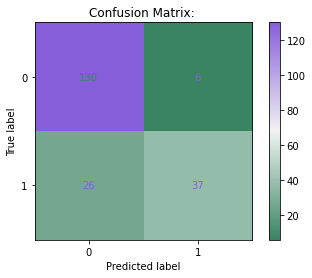

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       136
           1       0.86      0.59      0.70        63

    accuracy                           0.84       199
   macro avg       0.85      0.77      0.79       199
weighted avg       0.84      0.84      0.83       199




In [53]:
mf.plot_classifier_scores(rf, X_val, y_val, y_hat_val_rf)

As we see on the new - validation data Random Forest doesn't do so well in predicting '1' correctly and had miss classified 'ones' as 'zeros' even 26 times. Let's see what features were the most important.

* Scoring features.

In [54]:
for name, score in zip(X_train.columns, rf.feature_importances_):
    print(name, score)

age 0.15152900755504115
employment_type 0.014308628621769794
graduate_or_not 0.014675284932843535
annual_income 0.3896414794033552
family_members 0.11430627715675719
chronic_diseases 0.02155266441575658
frequent_flyer 0.020099004959315672
ever_travelled_abroad 0.10241772469011443
annual_income_per_person 0.12900188786627484
traveller 0.04246804039877163


So in the next part let's try to take only those features, which got the coefficient over 0.1.

### 2.5.2. Random Forest with selected less features

Selecting most important features.

In [79]:
X_train_less = X_train.copy()
X_train_less = X_train_less.drop(
    columns=[
        "employment_type",
        "graduate_or_not",
        "chronic_diseases",
        "frequent_flyer",
        "traveller",
    ],
    axis=1,
)
X_train_less.columns

Index(['age', 'annual_income', 'family_members', 'ever_travelled_abroad',
       'annual_income_per_person'],
      dtype='object')

In [56]:
X_val_less = X_val.copy()
X_val_less = X_val_less.drop(columns = ['employment_type', 'graduate_or_not', 'chronic_diseases', 'frequent_flyer', 'traveller'], axis=1)
X_val_less.columns

Index(['age', 'annual_income', 'family_members', 'ever_travelled_abroad',
       'annual_income_per_person'],
      dtype='object')

* Let's see if optuna will suggest something else if training on this data.

In [ ]:
study = optuna.create_study(direction='maximize', study_name='RandomForestClassifier')
func = lambda trial: mf.random_forest_objective(trial, X_train_less, y_train)
study.optimize(func, n_trials=200)

In [58]:
trial_rf2 = study.best_trial
random_forest2 = trial_rf2.params
for key, value in random_forest2.items():
    print(f"\t\t{key}: {value}")

		n_estimators: 81
		max_depth: 5
		min_samples_split: 7
		min_samples_leaf: 2
		max_features: 2
		weight: None


So hyper parameters had changed, let's fit training data with less features.

In [59]:
rf2 = RandomForestClassifier(n_estimators=81, max_depth=5, min_samples_leaf=2, min_samples_split=7, max_features=2, oob_score=True)
rf2.fit(X_train_less, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_leaf=2,
                       min_samples_split=7, n_estimators=81, oob_score=True)

In [60]:
rf2.oob_score_

0.8256765261170548

Accuracy on 'left'from training data looks the same. Let's predict on training and validation data.

In [61]:
y_hat_train_rf2 = rf2.predict(X_train_less)
y_hat_val_rf2 = rf2.predict(X_val_less)

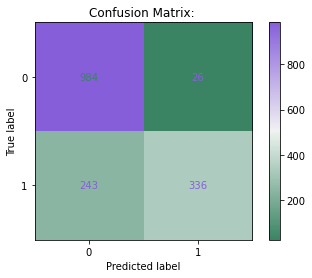

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1010
           1       0.93      0.58      0.71       579

    accuracy                           0.83      1589
   macro avg       0.87      0.78      0.80      1589
weighted avg       0.85      0.83      0.82      1589




In [62]:
mf.plot_classifier_scores(rf2, X_train_less, y_train, y_hat_train_rf2)

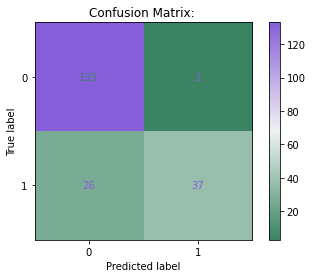

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       136
           1       0.93      0.59      0.72        63

    accuracy                           0.85       199
   macro avg       0.88      0.78      0.81       199
weighted avg       0.86      0.85      0.84       199




In [63]:
mf.plot_classifier_scores(rf2, X_val_less, y_val, y_hat_val_rf2)

This Random Forest model did a little bit better on f1 score, but the recall of guessing '1' is actually totally the same.

### 2.5.3. Random Forest with up sampled data and most important features

* Up sampling data with SMOTE.

In [75]:
upsample = SMOTE()
X_train_up, y_train_up = upsample.fit_resample(X_train_less, y_train)
counter = Counter(y_train_up)
print(counter)
print(X_train_up.shape)

Counter({1: 1010, 0: 1010})
(2020, 5)


* Let's fit this up sampled data.

In [65]:
rf3 = RandomForestClassifier(n_estimators=471, max_depth=5, min_samples_leaf=2, min_samples_split=2, max_features=2, oob_score=True)
rf3.fit(X_train_less, y_train)

RandomForestClassifier(max_depth=5, max_features=2, min_samples_leaf=2,
                       n_estimators=471, oob_score=True)

In [66]:
rf2.oob_score_

0.8256765261170548

Accuracy looks the same.

In [68]:
y_hat_train_rf3 = rf3.predict(X_train_up)
y_hat_val_rf3 = rf3.predict(X_val_less)

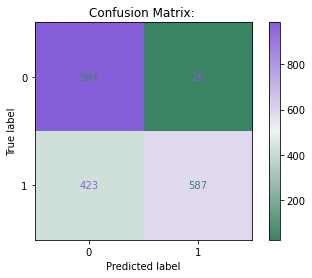

              precision    recall  f1-score   support

           0       0.70      0.97      0.81      1010
           1       0.96      0.58      0.72      1010

    accuracy                           0.78      2020
   macro avg       0.83      0.78      0.77      2020
weighted avg       0.83      0.78      0.77      2020




In [69]:
mf.plot_classifier_scores(rf3, X_train_up, y_train_up, y_hat_train_rf3)

Even on training data up sampling did not help, it seems it made more noise and that's all.

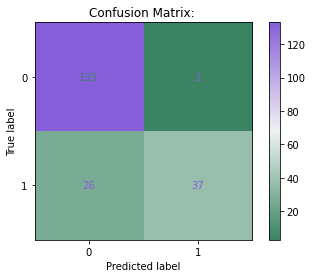

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       136
           1       0.93      0.59      0.72        63

    accuracy                           0.85       199
   macro avg       0.88      0.78      0.81       199
weighted avg       0.86      0.85      0.84       199




In [70]:
mf.plot_classifier_scores(rf3, X_val_less, y_val, y_hat_val_rf3)

So up sampling did not help, my Random Forest is still predicting 'ones' - that is people, who have interest in insurance, actually in the same way: racall - 0.59, f1 - 0.72.

# Conclusion

The best performance was from the tuned SVC model, trained on data (with all features), without duplicates.
So now, let's try to get the hyper parameters of SVC, given only the data without duplicates, train it one more time and then test on the test data, that was'nt used until now.

In [71]:
mf.SVC_randomized_search(X_train_no_dupl, y_train_no_dupl, pipe_sv)

Best params:
{'classifier': SVC(C=0.750385268090156, class_weight='balanced', gamma=0.1), 'classifier__C': 0.750385268090156, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Best f1 score in randomized search:
0.6594154796283853


In [73]:
final_SVC = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(C=0.750385268090156, class_weight="balanced", gamma=0.1)),
    ]
)
final_SVC.fit(X_train_no_dupl, y_train_no_dupl)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'annual_income',
                                                   'family_members',
                                                   'annual_income_per_person'])])),
                ('classifier',
                 SVC(C=0.750385268090156, class_weight='balanced', gamma=0.1))])

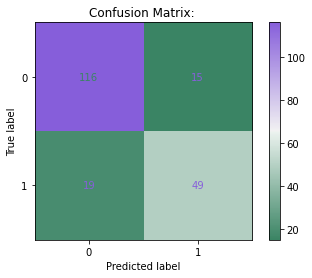

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       131
           1       0.77      0.72      0.74        68

    accuracy                           0.83       199
   macro avg       0.81      0.80      0.81       199
weighted avg       0.83      0.83      0.83       199




In [76]:
y_hat_test = final_SVC.predict(X_test)
mf.plot_classifier_scores(final_SVC, X_test, y_test, y_hat_test)

So we got the highest recall and f1 score, in the predicting '1' - people, who are interested in insurance, the number of miss classified '1' - got a little bit lower. Total accuracy is actually the highest. Let's see the precision/recall curve as it is used having data imbalance.

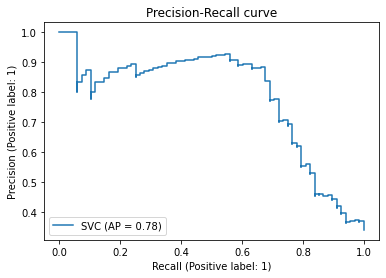

In [77]:
display = PrecisionRecallDisplay.from_estimator(
    final_SVC, X_test, y_test, name='SVC'
)
_ = display.ax_.set_title('Precision-Recall curve')

It seems my classifier is doing better than baseline classifier, so in that point it's ok.
For further improvement, i think it need's more data to be sampled, as it is too small (the age feature is to narrow, more information about health and etc.). Then, with larger data set, more features could be engineered.